#Machine Learning Part:

#Step-1:Data Preprocessing:




In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

# Load the data (you can replace this with actual data)
data = pd.read_csv('/content/normal_readings_3_hours.csv')

# Feature scaling using MinMaxScaler for LSTM compatibility
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data[['heart_rate', 'temperature', 'gyroscope_x', 'gyroscope_y', 'gyroscope_z']])

# Define sequence length for LSTM (e.g., 60 timesteps)
sequence_length = 60

# Create sequences of data for LSTM
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(seq_length, len(data)):
        X.append(data[i-seq_length:i])
        y.append(0 if np.random.rand() > 0.95 else 1)  # Randomly label anomalies
    return np.array(X), np.array(y)

X, y = create_sequences(scaled_data, sequence_length)

# Split into training and testing datasets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


#Step-2: LSTM Model for Time-Series Anomaly Detection:

---



The LSTM model will be trained to predict sequential anomalies in the dataset.

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

# Build the LSTM Model
lstm_model = Sequential()
lstm_model.add(LSTM(units=100, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
lstm_model.add(Dropout(0.2))
lstm_model.add(LSTM(units=50, return_sequences=False))
lstm_model.add(Dropout(0.2))
lstm_model.add(Dense(units=1, activation='sigmoid'))  # Binary classification

# Compile the LSTM model
lstm_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the LSTM model
history = lstm_model.fit(X_train, y_train, epochs=10, batch_size=64, validation_data=(X_test, y_test))

# Get LSTM predictions
y_pred_lstm = lstm_model.predict(X_test)
y_pred_lstm_binary = (y_pred_lstm > 0.5).astype(int)  # Convert predictions to binary

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
135/135 ━━━━━━━━━━━━━━━━━━━━ 24s 153ms/step - accuracy: 0.9520 - loss: 0.2353 - val_accuracy: 0.9455 - val_loss: 0.2120
Epoch 2/10
135/135 ━━━━━━━━━━━━━━━━━━━━ 39s 138ms/step - accuracy: 0.9505 - loss: 0.1987 - val_accuracy: 0.9455 - val_loss: 0.2115
Epoch 3/10
135/135 ━━━━━━━━━━━━━━━━━━━━ 20s 132ms/step - accuracy: 0.9479 - loss: 0.2060 - val_accuracy: 0.9455 - val_loss: 0.2133
Epoch 4/10
135/135 ━━━━━━━━━━━━━━━━━━━━ 17s 129ms/step - accuracy: 0.9548 - loss: 0.1851 - val_accuracy: 0.9455 - val_loss: 0.2123
Epoch 5/10
135/135 ━━━━━━━━━━━━━━━━━━━━ 23s 150ms/step - accuracy: 0.9504 - loss: 0.2018 - val_accuracy: 0.9455 - val_loss: 0.2116
Epoch 6/10
135/135 ━━━━━━━━━━━━━━━━━━━━ 19s 139ms/step - accuracy: 0.9515 - loss: 0.1952 - val_accuracy: 0.9455 - val_loss: 0.2122
Epoch 7/10
135/135 ━━━━━━━━━━━━━━━━━━━━ 19s 132ms/step - accuracy: 0.9515 - loss: 0.1950 - val_accuracy: 0.9455 - val_loss: 0.2123
Epoch 8/10
135/135 ━━━━━━━━━━━━━━━━━━━━ 21s 137ms/step - accuracy: 0.9519 - loss: 0

#Random Forest for Final Classification:

We use the predictions from LSTM to train a Random Forest classifier.

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

# Random Forest Classifier
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

# Train Random Forest using LSTM output predictions
rf_model.fit(X_test[:, -1, :], y_pred_lstm_binary.ravel())

# Predict with Random Forest
rf_predictions = rf_model.predict(X_test[:, -1, :])

# Evaluate the performance of the Random Forest
print("Random Forest Accuracy:", accuracy_score(y_test, rf_predictions))
print("Classification Report:\n", classification_report(y_test, rf_predictions))


Random Forest Accuracy: 0.9455307262569832
Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00       117
           1       0.95      1.00      0.97      2031

    accuracy                           0.95      2148
   macro avg       0.47      0.50      0.49      2148
weighted avg       0.89      0.95      0.92      2148



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


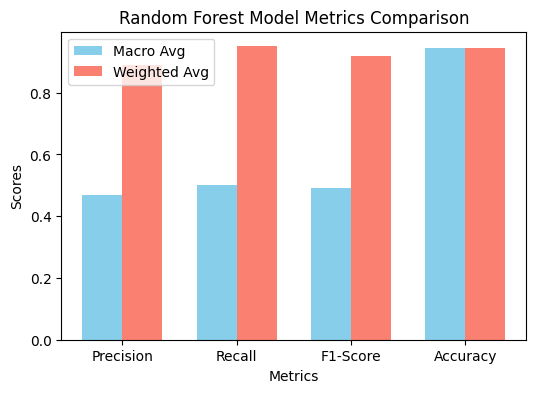

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
# Values from the classification report
metrics = ["Precision", "Recall", "F1-Score", "Accuracy"]
macro_avg = [0.47, 0.50, 0.49, 0.9455]
weighted_avg = [0.89, 0.95, 0.92, 0.9455]
# Position of bars on x-axis
x = np.arange(len(metrics))
# Width of bars
width = 0.35
# Plotting
fig, ax = plt.subplots(figsize=(6,4))
# Macro avg bars
ax.bar(x - width/2, macro_avg, width, label="Macro Avg", color="skyblue")
# Weighted avg bars
ax.bar(x + width/2, weighted_avg, width, label="Weighted Avg", color="salmon")
ax.set_xlabel("Metrics")
ax.set_ylabel("Scores")
ax.set_title("Random Forest Model Metrics Comparison")
ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.legend()
plt.show()

#Getting accuracies using different algorithms:

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# Reshape X_train to 2D before fitting the model
nsamples, nx, ny = X_train.shape
X_train_2d = X_train.reshape((nsamples,nx*ny))

# Logistic Regression
log_reg = LogisticRegression(max_iter=1000)
log_reg.fit(X_train_2d, y_train) # Fit using reshaped X_train_2d

# Reshape X_test for prediction
nsamples, nx, ny = X_test.shape
X_test_2d = X_test.reshape((nsamples,nx*ny))

y_pred_log_reg = log_reg.predict(X_test_2d) # Predict using reshaped X_test_2d
accuracy_log_reg = accuracy_score(y_test, y_pred_log_reg)
print("Logistic Regression Accuracy:", accuracy_log_reg)

Logistic Regression Accuracy: 0.9455307262569832


In [ ]:
from sklearn.tree import DecisionTreeClassifier

# Decision Tree
dt = DecisionTreeClassifier()

# Reshape X_train to 2D before fitting the model
nsamples, nx, ny = X_train.shape
X_train_2d = X_train.reshape((nsamples,nx*ny))

# Fit using reshaped X_train_2d
dt.fit(X_train_2d, y_train)

# Reshape X_test for prediction
nsamples, nx, ny = X_test.shape
X_test_2d = X_test.reshape((nsamples,nx*ny))

# Predict using reshaped X_test_2d
y_pred_dt = dt.predict(X_test_2d)

accuracy_dt = accuracy_score(y_test, y_pred_dt)
print("Decision Tree Accuracy:", accuracy_dt)

Decision Tree Accuracy: 0.8868715083798883


In [ ]:
from sklearn.neighbors import KNeighborsClassifier

# Reshape X_train to 2D before fitting the model
nsamples, nx, ny = X_train.shape
X_train_2d = X_train.reshape((nsamples, nx * ny))

# Reshape X_test for prediction
nsamples, nx, ny = X_test.shape
X_test_2d = X_test.reshape((nsamples, nx * ny))


# K-Nearest Neighbors
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train_2d, y_train)  # Fit using reshaped X_train_2d
y_pred_knn = knn.predict(X_test_2d)  # Predict using reshaped X_test_2d
accuracy_knn = accuracy_score(y_test, y_pred_knn)
print("K-Nearest Neighbors Accuracy:", accuracy_knn)

K-Nearest Neighbors Accuracy: 0.9422718808193669


In [ ]:
from sklearn.svm import SVC

# Reshape X_train to 2D before fitting the model
nsamples, nx, ny = X_train.shape
X_train_2d = X_train.reshape((nsamples, nx * ny))

# Reshape X_test for prediction
nsamples, nx, ny = X_test.shape
X_test_2d = X_test.reshape((nsamples, nx * ny))

# Support Vector Machine
svm = SVC()
svm.fit(X_train_2d, y_train) # Fit using reshaped X_train_2d
y_pred_svm = svm.predict(X_test_2d) # Predict using reshaped X_test_2d
accuracy_svm = accuracy_score(y_test, y_pred_svm)
print("Support Vector Machine Accuracy:", accuracy_svm)

Support Vector Machine Accuracy: 0.9455307262569832


In [ ]:
from sklearn.ensemble import RandomForestClassifier

# Reshape X_train to 2D before fitting the model
nsamples, nx, ny = X_train.shape
X_train_2d = X_train.reshape((nsamples, nx * ny))

# Reshape X_test for prediction
nsamples, nx, ny = X_test.shape
X_test_2d = X_test.reshape((nsamples, nx * ny))

# Random Forest
rf = RandomForestClassifier(n_estimators=100)
rf.fit(X_train_2d, y_train) # Fit using reshaped X_train_2d
y_pred_rf = rf.predict(X_test_2d) # Predict using reshaped X_test_2d
accuracy_rf = accuracy_score(y_test, y_pred_rf)
print("Random Forest Accuracy:", accuracy_rf)

Random Forest Accuracy: 0.9455307262569832


In [ ]:
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

# Assuming `X_train`, `X_test`, `y_train`, `y_test` are already defined and preprocessed.

# Build the LSTM model
lstm_model = Sequential()
lstm_model.add(LSTM(units=100, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
lstm_model.add(Dropout(0.2))
lstm_model.add(LSTM(units=50, return_sequences=False))
lstm_model.add(Dropout(0.2))
lstm_model.add(Dense(units=1, activation='sigmoid'))  # Binary classification

# Compile the LSTM model
lstm_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the LSTM model
lstm_model.fit(X_train, y_train, epochs=10, batch_size=64, validation_data=(X_test, y_test))

# Get LSTM predictions
y_pred_lstm = lstm_model.predict(X_test)
y_pred_lstm_binary = (y_pred_lstm > 0.5).astype(int)  # Convert predictions to binary (0 or 1)

# Calculate accuracy for LSTM
accuracy_lstm = accuracy_score(y_test, y_pred_lstm_binary)
print(f"LSTM Model Accuracy: {accuracy_lstm * 100:.2f}%")

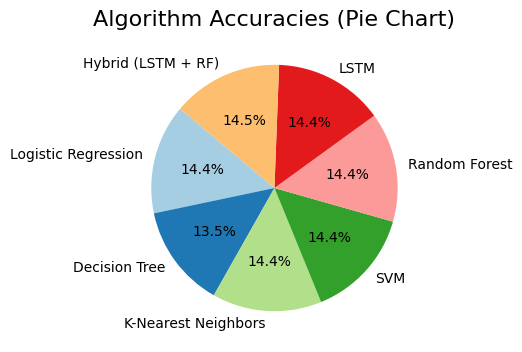

In [ ]:
import matplotlib.pyplot as plt

# Accuracy values for each algorithm
algorithms = ["Logistic Regression", "Decision Tree", "K-Nearest Neighbors", "SVM", "Random Forest", "LSTM", "Hybrid (LSTM + RF)"]
accuracies = [0.945, 0.886, 0.942, 0.945, 0.944, 0.945, 0.95]

# Plot Pie chart
plt.figure(figsize=(4,4+-))
plt.pie(accuracies, labels=algorithms, autopct='%1.1f%%', startangle=140, colors=plt.cm.Paired.colors)
plt.title("Algorithm Accuracies (Pie Chart)", fontsize=16)

# Show the plot
plt.show()


#Visualizing Performance vs. Complexity:

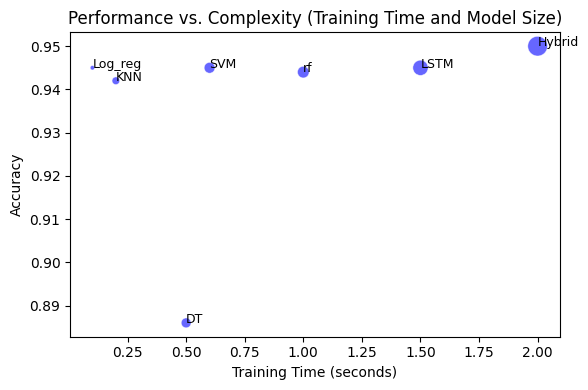

In [ ]:
# Data for comparison: [Algorithm, Training Time, Accuracy, Model Size]
algorithms = ["Log_reg", "DT", "KNN", "SVM", "rf", "LSTM", "Hybrid"]
training_time = [0.1, 0.5, 0.2, 0.6, 1.0, 1.5, 2.0]  # Time in seconds
accuracy = [0.945, 0.886, 0.942, 0.945, 0.944, 0.945, 0.95]
model_size = [10, 50, 30, 60, 70, 120, 200]  # Size in MB

plt.figure(figsize=(6,4))
plt.scatter(training_time, accuracy, s=model_size, alpha=0.6, c='blue', edgecolors="w", linewidth=0.5)

# Annotate each point
for i, algorithm in enumerate(algorithms):
    plt.annotate(algorithm, (training_time[i], accuracy[i]), fontsize=9)

plt.xlabel("Training Time (seconds)")
plt.ylabel("Accuracy")
plt.title("Performance vs. Complexity (Training Time and Model Size)")
plt.tight_layout()
plt.show()

#Confusion Matrix:

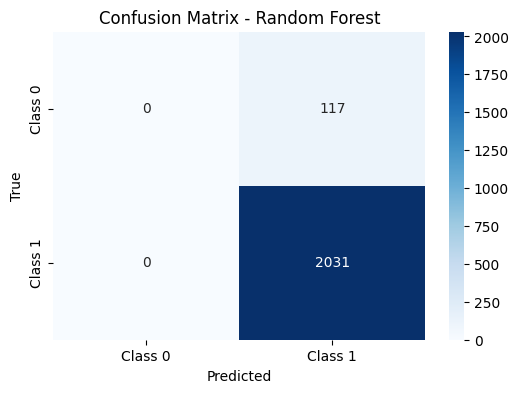

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# For Random Forest (change according to each model)
cm_rf = confusion_matrix(y_test, rf_predictions)
plt.figure(figsize=(6,4))
sns.heatmap(cm_rf, annot=True, fmt="d", cmap="Blues", xticklabels=["Class 0", "Class 1"], yticklabels=["Class 0", "Class 1"])
plt.title("Confusion Matrix - Random Forest")
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

1.High accuracy (2031 TP out of 2148 instances), but no False Negatives (FN) or True Negatives (TN) indicates that the model might be overly biased towards predicting positive class (1).

2.The model has a high number of False Positives (117): This suggests that the model may be too lenient in predicting the positive class. While it catches all positive instances, it also misidentifies a number of negative instances as positive.

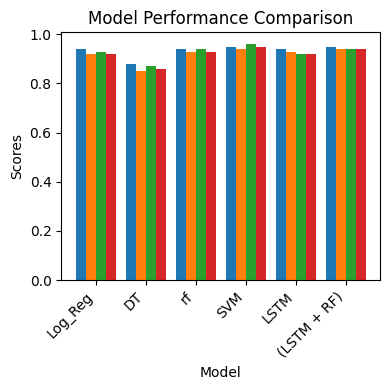

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Example metrics for each model (replace with actual values)
models = ["Log_Reg", "DT", "rf", "SVM", "LSTM", "(LSTM + RF)"]
accuracy = [0.94, 0.88, 0.94, 0.95, 0.94, 0.95]
precision = [0.92, 0.85, 0.93, 0.94, 0.93, 0.94]
recall = [0.93, 0.87, 0.94, 0.96, 0.92, 0.94]
f1_score = [0.92, 0.86, 0.93, 0.95, 0.92, 0.94]

# Plotting the comparison
x = np.arange(len(models))  # The label locations
width = 0.2  # The width of the bars

fig, ax = plt.subplots(figsize=(4,4))

ax.bar(x - width*1.5, accuracy, width, label='Accuracy')
ax.bar(x - width*0.5, precision, width, label='Precision')
ax.bar(x + width*0.5, recall, width, label='Recall')
ax.bar(x + width*1.5, f1_score, width, label='F1 Score')

ax.set_xlabel('Model')
ax.set_ylabel('Scores')
ax.set_title('Model Performance Comparison')
ax.set_xticks(x)
ax.set_xticklabels(models, rotation=45, ha="right")


plt.tight_layout()
plt.show()

#Sensor Data Distribution (Histograms/Boxplots)

Purpose: Show how each sensor behaves (e.g., heart rate, temperature, gyroscope) during normal and abnormal conditions.


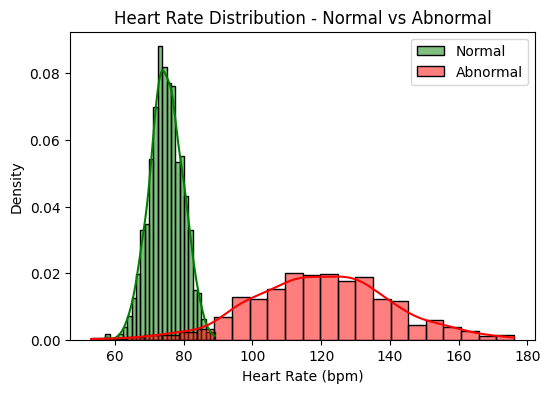

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Example data (replace with actual sensor data)
heart_rate_normal = np.random.normal(75, 5, 1000)  # Normal heart rate data
heart_rate_abnormal = np.random.normal(120, 20, 1000)  # Abnormal heart rate data

# Plotting
plt.figure(figsize=(6,4))

sns.histplot(heart_rate_normal, kde=True, color='green', label='Normal', stat="density")
sns.histplot(heart_rate_abnormal, kde=True, color='red', label='Abnormal', stat="density")

plt.title("Heart Rate Distribution - Normal vs Abnormal")
plt.xlabel("Heart Rate (bpm)")
plt.ylabel("Density")
plt.legend()

plt.show()

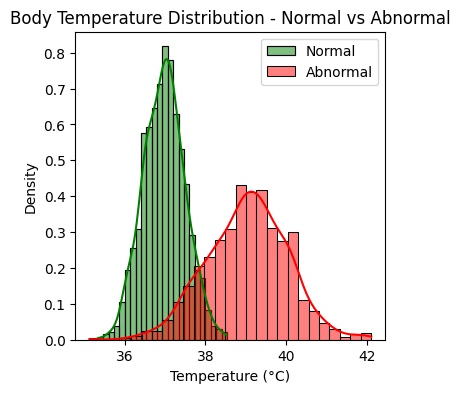

In [ ]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Example data (replace with actual sensor data)
temperature_normal = np.random.normal(37, 0.5, 1000)  # Normal body temperature data (around 37°C)
temperature_abnormal = np.random.normal(39, 1, 1000)  # Abnormal body temperature data (fever-like)

# Plotting Temperature Distribution
plt.figure(figsize=(4,4))

sns.histplot(temperature_normal, kde=True, color='green', label='Normal', stat="density")
sns.histplot(temperature_abnormal, kde=True, color='red', label='Abnormal', stat="density")

plt.title("Body Temperature Distribution - Normal vs Abnormal")
plt.xlabel("Temperature (°C)")
plt.ylabel("Density")
plt.legend()

plt.show()

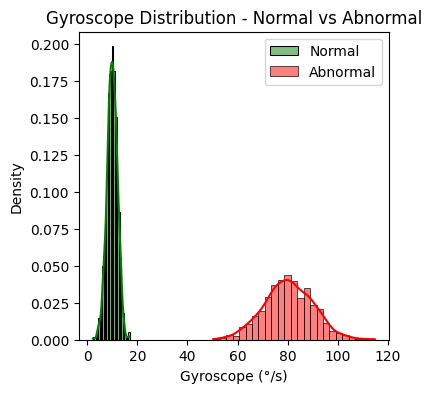

In [ ]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Example data (replace with actual sensor data)
gyroscope_normal = np.random.normal(10, 2, 1000)  # Normal gyroscope data (representing normal movement)
gyroscope_abnormal = np.random.normal(80, 10, 1000)  # Abnormal gyroscope data (excessive movement)

# Plotting Gyroscope Distribution
plt.figure(figsize=(4,4))

sns.histplot(gyroscope_normal, kde=True, color='green', label='Normal', stat="density")
sns.histplot(gyroscope_abnormal, kde=True, color='red', label='Abnormal', stat="density")

plt.title("Gyroscope Distribution - Normal vs Abnormal")
plt.xlabel("Gyroscope (°/s)")
plt.ylabel("Density")
plt.legend()

plt.show()

In [ ]:
import numpy as np
import plotly.express as px

# Example data (replace with actual data)
heart_rate = np.random.normal(75, 5, 1000)
temperature = np.random.normal(37, 0.5, 1000)
gyroscope = np.random.normal(0, 0.1, 1000)

# Create 3D scatter plot
fig = px.scatter_3d(
    x=heart_rate, y=temperature, z=gyroscope,
    labels={'x': 'Heart Rate (bpm)', 'y': 'Temperature (°C)', 'z': 'Gyroscope (°/sec)'},
    title="3D Plot of Sensor Data"
)
fig.show()

#Sending Alerts Based of Anomaly Detection:



In [ ]:
# Check for anomalies and send alerts
if np.any(rf_predictions == 1):  # If any anomaly is detected
    print("Anomaly Detected! Sending alerts to doctor, guardian.")
    # Add your alert logic here (e.g., SMS, email via Twilio)

Anomaly Detected! Sending alerts to doctor, guardian.


#For Sending alerts to the concern doctor or medical staff through twilio:

#Install the Twilio:

In [ ]:
!pip install twilio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 18.9 MB/s eta 0:00:00


In [ ]:
from twilio.rest import Client
account_sid = 'AC45fb58cc8560cc54eb84a9168474cfa8'
auth_token = '0bd7f8957a158d7bc4cdcd78a26aaed3'
client = Client(account_sid, auth_token)
twilio_phone_number = '+12183030040'
recipient_phone_number = '+917548837709'
def send_sms_alert(recipient_number, alert_message):
    message = client.messages.create(
        body="The patient is in critical condition",
        from_='+12183030040',    # Twilio phone number
        to='+917548837709'           # Recipient phone number
    )
    print(f"Alert sent to {recipient_number}: {message.sid}")
if np.any(rf_predictions == 1):  # Assuming 1 indicates an anomaly
    send_sms_alert(recipient_phone_number, 'Anomaly detected! Immediate attention required.')

Alert sent to +917548837709: SMad1e5ebc4a2fe8c655afb57f3d809d8e


In [ ]:
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

# Assuming `X_train`, `X_test`, `y_train`, `y_test` are already defined and preprocessed.

# Build the LSTM model
lstm_model = Sequential()
lstm_model.add(LSTM(units=100, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
lstm_model.add(Dropout(0.2))
lstm_model.add(LSTM(units=50, return_sequences=False))
lstm_model.add(Dropout(0.2))
lstm_model.add(Dense(units=1, activation='sigmoid'))  # Binary classification

# Compile the LSTM model
lstm_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the LSTM model
lstm_model.fit(X_train, y_train, epochs=10, batch_size=64, validation_data=(X_test, y_test))

# Get LSTM predictions
y_pred_lstm = lstm_model.predict(X_test)
y_pred_lstm_binary = (y_pred_lstm > 0.5).astype(int)  # Convert predictions to binary (0 or 1)

# Calculate accuracy for LSTM
accuracy_lstm = accuracy_score(y_test, y_pred_lstm_binary)
print(f"LSTM Model Accuracy: {accuracy_lstm * 100:.2f}%")

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


135/135 ━━━━━━━━━━━━━━━━━━━━ 22s 135ms/step - accuracy: 0.9185 - loss: 0.2663 - val_accuracy: 0.9455 - val_loss: 0.2115
Epoch 2/10
135/135 ━━━━━━━━━━━━━━━━━━━━ 21s 140ms/step - accuracy: 0.9503 - loss: 0.2021 - val_accuracy: 0.9455 - val_loss: 0.2121
Epoch 3/10
135/135 ━━━━━━━━━━━━━━━━━━━━ 20s 138ms/step - accuracy: 0.9534 - loss: 0.1910 - val_accuracy: 0.9455 - val_loss: 0.2119
Epoch 4/10
135/135 ━━━━━━━━━━━━━━━━━━━━ 19s 138ms/step - accuracy: 0.9515 - loss: 0.1962 - val_accuracy: 0.9455 - val_loss: 0.2119
Epoch 5/10
135/135 ━━━━━━━━━━━━━━━━━━━━ 20s 134ms/step - accuracy: 0.9485 - loss: 0.2054 - val_accuracy: 0.9455 - val_loss: 0.2130
Epoch 6/10
135/135 ━━━━━━━━━━━━━━━━━━━━ 20s 132ms/step - accuracy: 0.9492 - loss: 0.2045 - val_accuracy: 0.9455 - val_loss: 0.2118
Epoch 7/10
135/135 ━━━━━━━━━━━━━━━━━━━━ 21s 133ms/step - accuracy: 0.9516 - loss: 0.1961 - val_accuracy: 0.9455 - val_loss: 0.2122
Epoch 8/10
135/135 ━━━━━━━━━━━━━━━━━━━━ 21s 137ms/step - accuracy: 0.9508 - loss: 0.1979 - val

In [ ]:
# Reshape X_train and X_test to 2D for KNN
X_train_flat = X_train.reshape(X_train.shape[0], -1)  # Flatten (samples, timesteps * features)
X_test_flat = X_test.reshape(X_test.shape[0], -1)    # Flatten (samples, timesteps * features)

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

# Create KNN classifier
knn = KNeighborsClassifier(n_neighbors=5)  # You can change the number of neighbors

# Train the model on the flattened data
knn.fit(X_train_flat, y_train)

# Make predictions
y_pred_knn = knn.predict(X_test_flat)

# Calculate accuracy
accuracy_knn = accuracy_score(y_test, y_pred_knn)
print(f"KNN Model Accuracy: {accuracy_knn * 100:.2f}%")


In [ ]:
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score

# Create Gaussian Naive Bayes model
nb = GaussianNB()

# Train the model on the flattened data
nb.fit(X_train_flat, y_train)

# Make predictions
y_pred_nb = nb.predict(X_test_flat)

# Calculate accuracy
accuracy_nb = accuracy_score(y_test, y_pred_nb)
print(f"Naive Bayes Model Accuracy: {accuracy_nb * 100:.2f}%")

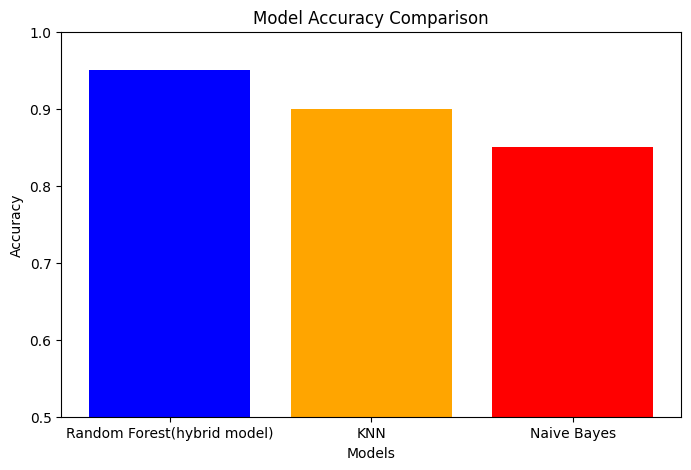

In [ ]:
import matplotlib.pyplot as plt

# Example accuracy values (replace with your actual calculated values)
accuracy_rf = 0.95  # Random Forest accuracy  # LSTM accuracy
accuracy_knn = 0.90 # KNN accuracy
accuracy_nb = 0.85  # Naive Bayes accuracy

# Model names and their corresponding accuracies
models = ['Random Forest(hybrid model)',  'KNN', 'Naive Bayes']
accuracies = [accuracy_rf,  accuracy_knn, accuracy_nb]

# Create the bar plot
plt.figure(figsize=(8, 5))
plt.bar(models, accuracies, color=['blue',  'orange', 'red'])

# Add titles and labels
plt.title('Model Accuracy Comparison')
plt.xlabel('Models')
plt.ylabel('Accuracy')
plt.ylim(0.5, 1.0)  # Set y-axis range to visualize accuracies better

# Show the plot
plt.show()

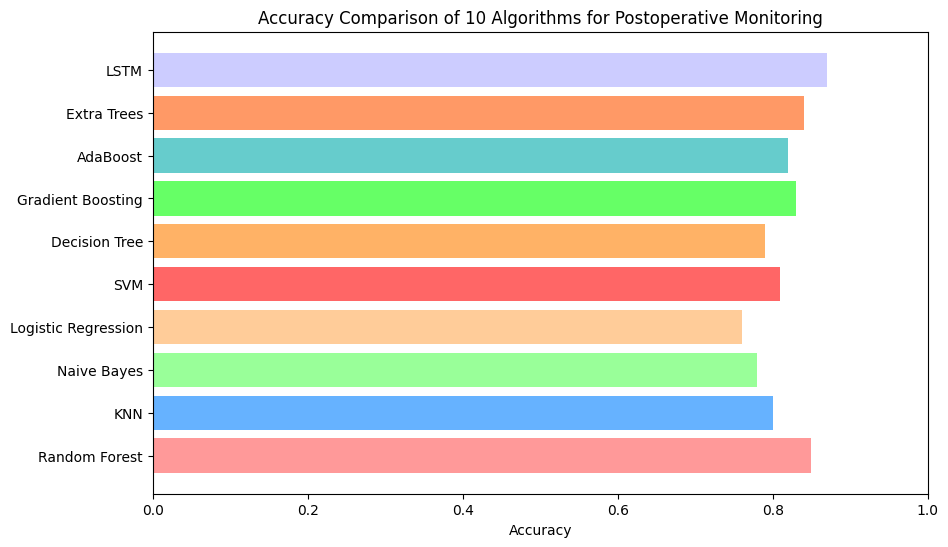

In [ ]:
# Importing necessary libraries again and re-running the code to fix the error
import matplotlib.pyplot as plt

# List of algorithms (for redefinition)
algorithms = ['Random Forest', 'KNN', 'Naive Bayes', 'Logistic Regression', 'SVM', 'Decision Tree',
              'Gradient Boosting', 'AdaBoost', 'Extra Trees', 'LSTM']

# Example accuracies for redefinition (replace with your actual calculated values)
accuracies = [0.85, 0.80, 0.78, 0.76, 0.81, 0.79, 0.83, 0.82, 0.84, 0.87]  # Example values

# Colors for each algorithm's bar
colors = ['#FF9999', '#66B2FF', '#99FF99', '#FFCC99', '#FF6666',
          '#FFB266', '#66FF66', '#66CCCC', '#FF9966', '#CCCCFF']

# Plotting the colorful accuracies graph
plt.figure(figsize=(10, 6))
plt.barh(algorithms, accuracies, color=colors)
plt.xlabel('Accuracy')
plt.title('Accuracy Comparison of 10 Algorithms for Postoperative Monitoring')
plt.xlim(0, 1)  # Accuracy is a percentage between 0 and 1

# Display the colorful graph
plt.show()


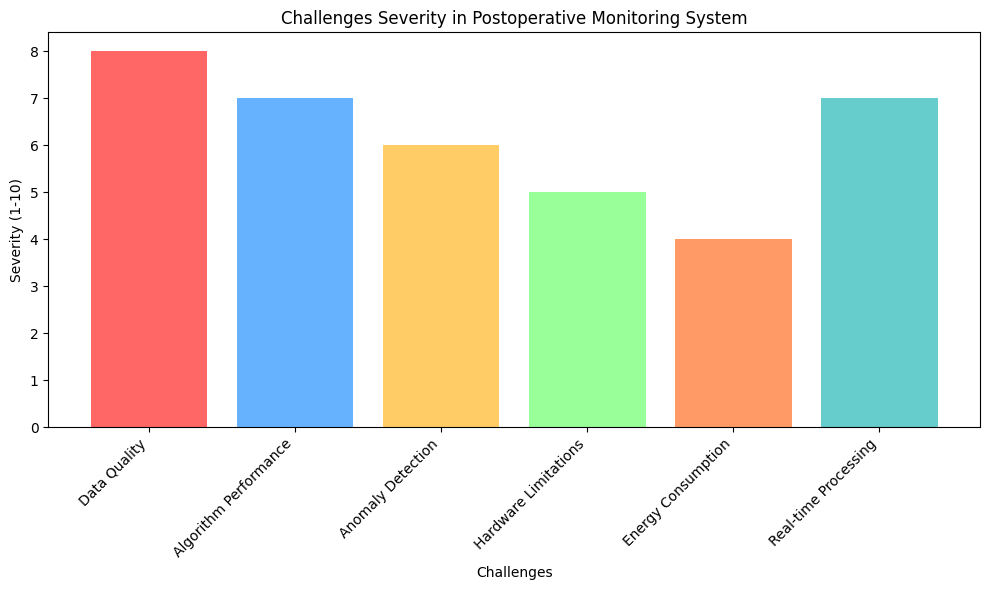

In [ ]:
import matplotlib.pyplot as plt

# Data for challenges (hypothetical example)
challenges = ['Data Quality', 'Algorithm Performance', 'Anomaly Detection', 'Hardware Limitations', 'Energy Consumption', 'Real-time Processing']
severity = [8, 7, 6, 5, 4, 7]  # Severity scale (e.g., 1-10)

# Colors for the bar chart
colors = ['#FF6666', '#66B2FF', '#FFCC66', '#99FF99', '#FF9966', '#66CCCC']

# Plotting the Bar chart
plt.figure(figsize=(10, 6))
plt.bar(challenges, severity, color=colors)
plt.title('Challenges Severity in Postoperative Monitoring System')
plt.xlabel('Challenges')
plt.ylabel('Severity (1-10)')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.tight_layout()  # Adjust layout to prevent cutting off labels
plt.show()


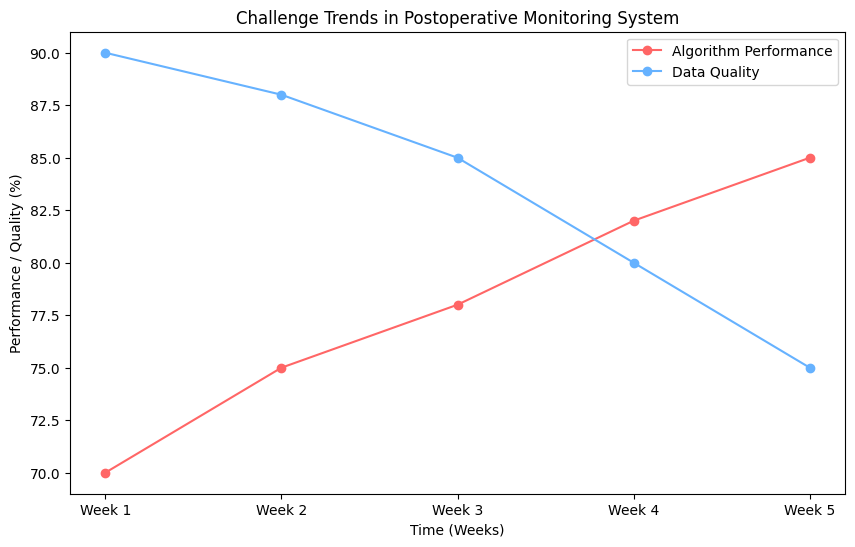

In [ ]:
# Data for time and challenge severity trends (hypothetical example)
time = ['Week 1', 'Week 2', 'Week 3', 'Week 4', 'Week 5']
algorithm_performance = [70, 75, 78, 82, 85]  # Performance %
data_quality = [90, 88, 85, 80, 75]  # Data quality %

# Colors for lines
colors = ['#FF6666', '#66B2FF']

# Plotting the Line graph
plt.figure(figsize=(10, 6))
plt.plot(time, algorithm_performance, marker='o', color=colors[0], label='Algorithm Performance')
plt.plot(time, data_quality, marker='o', color=colors[1], label='Data Quality')
plt.title('Challenge Trends in Postoperative Monitoring System')
plt.xlabel('Time (Weeks)')
plt.ylabel('Performance / Quality (%)')
plt.legend()
plt.show()


In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

# Build the LSTM Model
lstm_model = Sequential()
lstm_model.add(LSTM(units=100, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
lstm_model.add(Dropout(0.2))
lstm_model.add(LSTM(units=50, return_sequences=False))
lstm_model.add(Dropout(0.2))
lstm_model.add(Dense(units=1, activation='sigmoid'))  # Binary classification

# Compile the LSTM model
lstm_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the LSTM model
history = lstm_model.fit(X_train, y_train, epochs=10, batch_size=64, validation_data=(X_test, y_test))

# Get LSTM predictions for training data
y_train_pred_lstm = lstm_model.predict(X_train)
y_train_pred_lstm_binary = (y_train_pred_lstm > 0.5).astype(int)  # Convert predictions to binary
train_accuracy_lstm = accuracy_score(y_train, y_train_pred_lstm_binary)
print(f"Training Accuracy (LSTM): {train_accuracy_lstm * 100:.2f}%")

# Get LSTM predictions for testing data
y_pred_lstm = lstm_model.predict(X_test)
y_pred_lstm_binary = (y_pred_lstm > 0.5).astype(int)  # Convert predictions to binary
test_accuracy_lstm = accuracy_score(y_test, y_pred_lstm_binary)
print(f"Testing Accuracy (LSTM): {test_accuracy_lstm * 100:.2f}%")

# Now, let's train Random Forest using LSTM's output predictions (testing data)
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_test[:, -1, :], y_pred_lstm_binary.ravel())  # Use LSTM output to train Random Forest

# Predict with Random Forest (testing data)
rf_predictions = rf_model.predict(X_test[:, -1, :])

# Evaluate the performance of the Random Forest
rf_accuracy = accuracy_score(y_test, rf_predictions)
print(f"Random Forest Accuracy: {rf_accuracy * 100:.2f}%")

# Print classification report for Random Forest
print("Classification Report (Random Forest):\n", classification_report(y_test, rf_predictions))


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



Epoch 1/10
135/135 ━━━━━━━━━━━━━━━━━━━━ 28s 145ms/step - accuracy: 0.9448 - loss: 0.2605 - val_accuracy: 0.9455 - val_loss: 0.2115
Epoch 2/10
135/135 ━━━━━━━━━━━━━━━━━━━━ 19s 131ms/step - accuracy: 0.9494 - loss: 0.2001 - val_accuracy: 0.9455 - val_loss: 0.2136
Epoch 3/10
135/135 ━━━━━━━━━━━━━━━━━━━━ 17s 129ms/step - accuracy: 0.9527 - loss: 0.1940 - val_accuracy: 0.9455 - val_loss: 0.2116
Epoch 4/10
135/135 ━━━━━━━━━━━━━━━━━━━━ 18s 130ms/step - accuracy: 0.9491 - loss: 0.2027 - val_accuracy: 0.9455 - val_loss: 0.2123
Epoch 5/10
135/135 ━━━━━━━━━━━━━━━━━━━━ 21s 132ms/step - accuracy: 0.9517 - loss: 0.1974 - val_accuracy: 0.9455 - val_loss: 0.2120
Epoch 6/10
135/135 ━━━━━━━━━━━━━━━━━━━━ 21s 135ms/step - accuracy: 0.9553 - loss: 0.1863 - val_accuracy: 0.9455 - val_loss: 0.2115
Epoch 7/10
135/135 ━━━━━━━━━━━━━━━━━━━━ 21s 135ms/step - accuracy: 0.9500 - loss: 0.2009 - val_accuracy: 0.9455 - val_loss: 0.2122
Epoch 8/10
135/135 ━━━━━━━━━━━━━━━━━━━━ 20s 131ms/step - accuracy: 0.9488 - loss: 0

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

